## CNN pour tout station

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import layers ,optimizers,models,regularizers
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from codecarbon import EmissionsTracker
import logging

code carbon

In [31]:
tracker = EmissionsTracker(
    project_name="cnn_window_glissant",
    log_level=logging.INFO,
    output_file="model_cnn_window_glissant.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=5,
    allow_multiple_runs=True 
)

[codecarbon WARNING @ 10:34:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:34:16] [setup] RAM Tracking...
[codecarbon INFO @ 10:34:16] [setup] CPU Tracking...
[codecarbon WARNING @ 10:34:16] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU



[codecarbon INFO @ 10:34:18] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
[codecarbon INFO @ 10:34:18] [setup] GPU Tracking...
[codecarbon INFO @ 10:34:18] No GPU found.
[codecarbon INFO @ 10:34:18] >>> Tracker's metadata:
[codecarbon INFO @ 10:34:18]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 10:34:18]   Python version: 3.8.5
[codecarbon INFO @ 10:34:18]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 10:34:18]   Available RAM : 15.852 GB
[codecarbon INFO @ 10:34:18]   CPU count: 8
[codecarbon INFO @ 10:34:18]   CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz
[codecarbon INFO @ 10:34:18]   GPU count: None
[codecarbon INFO @ 10:34:18]   GPU model: None
[codecarbon INFO @ 10:34:18] Saving emissions data to file d:\CODE\code_python\integre\cnn\5SDBDproject\emissions\model_cnn_window_glissant.csv


In [32]:
file_path = 'merged_all_bikes_weather_events.csv'
data = pd.read_csv(file_path)
data['timestamp'] = pd.to_datetime(data['timestamp']).astype('int64') 
data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data=data.sort_values('timestamp')
print(data.columns.to_list())
feature_to_normaliser=['bike_stands','available_bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'wind_speed', 'counter_events']
other_features = [col for col in data.columns if col not in feature_to_normaliser]
new_column_order=feature_to_normaliser+other_features
data=data[new_column_order]
print(data.columns.to_list())
num_features_to_normalize=len(feature_to_normaliser)

['timestamp', 'number', 'status', 'available_bike_stands', 'available_bikes', 'bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'is_rainy', 'wind_speed', 'counter_events', 'day_of_week', 'is_weekend']
['bike_stands', 'available_bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'wind_speed', 'counter_events', 'timestamp', 'number', 'status', 'available_bikes', 'is_rainy', 'day_of_week', 'is_weekend']


Normaliser

In [33]:
### verifier ordonne
data[:5]

,bike_stands,available_bike_stands,visibility_distance,current_temperature,feels_like_temperature,wind_speed,counter_events,timestamp,number,status,available_bikes,is_rainy,day_of_week,is_weekend
0,20,7,10000.0,6.99,6.17,5.54,0,1733940000000000000,259,1,13,0.0,2,0
870608,16,11,10000.0,6.99,6.17,5.54,0,1733940000000000000,257,1,5,0.0,2,0
869769,13,2,10000.0,6.99,6.17,5.54,0,1733940000000000000,309,1,10,0.0,2,0
869768,17,16,10000.0,6.99,6.17,5.54,0,1733940000000000000,207,1,1,0.0,2,0
868965,22,5,10000.0,6.99,6.17,5.54,0,1733940000000000000,126,1,17,0.0,2,0


In [34]:
X = data.drop(columns=['available_bikes']).values  
y = data['available_bikes'].values 
## test et train
split_index = int(0.8 * len(X))  
X_train_raw, X_test_raw = X[:split_index], X[split_index:]
y_train_raw, y_test_raw = y[:split_index], y[split_index:]
scaler_X = StandardScaler()
X_train_to_normalize = X_train_raw[:, :num_features_to_normalize]
X_train_not_to_normalize = X_train_raw[:, num_features_to_normalize:]
X_train_feature_normalized = scaler_X.fit_transform(X_train_to_normalize)

X_test_to_normalize = X_test_raw[:, :num_features_to_normalize]
X_test_not_to_normalize = X_test_raw[:, num_features_to_normalize:]
X_test_to_feature_normalized = scaler_X.transform(X_test_to_normalize)

X_train = np.hstack([X_train_feature_normalized, X_train_not_to_normalize])
X_test = np.hstack([X_test_to_feature_normalized, X_test_not_to_normalize])

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test_raw.reshape(-1, 1)).flatten()
print("\n x train shape:",X_train.shape)
print("\n x test shape:",X_test.shape)
print("\n y train shape:",y_train.shape)
print("\n y test shape:",y_test.shape)


 x train shape: (950319, 13)

 x test shape: (237580, 13)

 y train shape: (950319,)

 y test shape: (237580,)


window glissant

In [35]:
station_column_index = list(data.drop(columns='available_bikes').columns).index('number')

print(station_column_index)
station_ids = X[:, station_column_index]
print(station_ids)
unique_stations = np.unique(station_ids)
print(len(unique_stations))

8
[259. 257. 309. ... 265.  65. 396.]
382


In [36]:
def create_sliding_window_grouped(X, y, station_ids, time_steps):
    X_seq_all, y_seq_all, station_seq_all = [], [], []
    unique_stations = np.unique(station_ids)

    for station in unique_stations:
        station_indices = np.where(station_ids == station)[0]
        X_station = X[station_indices]
        y_station = y[station_indices]
        for i in range(len(X_station) - time_steps):
            X_window = np.hstack([X_station[i:i + time_steps], y_station[i:i + time_steps].reshape(-1, 1)])
            X_seq_all.append(X_window)
            y_seq_all.append(y_station[i + time_steps])
            station_seq_all.append(station)

    return np.array(X_seq_all), np.array(y_seq_all), np.array(station_seq_all)
time_steps=4
X_train_seq, y_train_seq, station_train_seq = create_sliding_window_grouped(X_train, y_train, station_ids[:split_index], time_steps)
X_test_seq, y_test_seq, station_test_seq = create_sliding_window_grouped(X_test, y_test, station_ids[split_index:], time_steps)

print("\ntrain data:")
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("station_train_seq shape:", station_train_seq.shape)

print("\ntest data:")
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)
print("station_test_seq shape:", station_test_seq.shape)


train data:
X_train_seq shape: (948791, 4, 14)
y_train_seq shape: (948791,)
station_train_seq shape: (948791,)

test data:
X_test_seq shape: (236056, 4, 14)
y_test_seq shape: (236056,)
station_test_seq shape: (236056,)


model cnn

verifier data tranning

In [37]:
print(data.drop(columns='available_bikes').columns.to_list())
print(X_train_seq[1])
print(y_train_seq[1])
print(station_train_seq[1])

['bike_stands', 'available_bike_stands', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'wind_speed', 'counter_events', 'timestamp', 'number', 'status', 'is_rainy', 'day_of_week', 'is_weekend']
[[ 1.72191139e-01 -1.03536827e+00  6.01042690e-01 -5.99491337e-02
   1.07119318e-01 -6.82358561e-01  2.39245755e+00  1.73394090e+18
   1.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  1.72958431e+00]
 [ 1.72191139e-01 -8.77475701e-01  6.01042690e-01 -1.34252842e-01
  -1.50572189e-02 -6.29059375e-01  2.39245755e+00  1.73394180e+18
   1.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  1.31811055e+00]
 [ 1.72191139e-01 -5.61690556e-01  6.01042690e-01 -2.08556550e-01
  -1.37233756e-01 -5.75760190e-01  2.39245755e+00  1.73394270e+18
   1.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  9.06636786e-01]
 [ 1.72191139e-01 -2.45905412e-01  6.01042690e-01 -2.82860258e-01
  -2.59410293e-0

In [ ]:
model = models.Sequential([
    layers.Conv1D(filters=16,  
                  kernel_size=2, 
                  activation='relu', 
                  input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                  kernel_regularizer=regularizers.l2(0.001)
                  ),  
    layers.BatchNormalization(),  
    layers.MaxPooling1D(pool_size=2, strides=1),
    layers.Dropout(0.15),
 
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 3, 16)             464       
                                                                 
 batch_normalization_4 (Bat  (None, 3, 16)             64        
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 2, 16)             0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 2, 16)             0         
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [39]:
val_size = int(0.6 * len(X_test_seq))
X_test_seq, X_val = X_test_seq[:val_size], X_test_seq[val_size:]
y_test_seq, y_val = y_test_seq[:val_size], y_test_seq[val_size:]
print("\ntrain data:")
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)

print("\nval data:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("\ntest data:")
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)


train data:
X_train_seq shape: (948791, 4, 14)
y_train_seq shape: (948791,)

val data:
X_val shape: (94423, 4, 14)
y_val shape: (94423,)

test data:
X_test_seq shape: (141633, 4, 14)
y_test_seq shape: (141633,)


In [40]:

from tensorflow.keras import callbacks
print("Training the model...")
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        min_delta=0.001
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]
tracker.start()
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    shuffle=False,
    callbacks=[callbacks] 
)

tracker.stop()


Training the model...
Epoch 1/30
  550/14825 [>.............................] - ETA: 58s - loss: 2.5266 - mae: 1.2562

[codecarbon INFO @ 10:34:50] Energy consumed for RAM : 0.000008 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:34:50] Energy consumed for all CPUs : 0.000020 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:34:50] 0.000028 kWh of electricity used since the beginning.


 1681/14825 [==>...........................] - ETA: 56s - loss: 1.8159 - mae: 1.0776

[codecarbon INFO @ 10:34:55] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.944325923919678 W


 1696/14825 [==>...........................] - ETA: 56s - loss: 1.8045 - mae: 1.0735

[codecarbon INFO @ 10:34:55] Energy consumed for all CPUs : 0.000039 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:34:55] 0.000055 kWh of electricity used since the beginning.


 2878/14825 [====>.........................] - ETA: 50s - loss: 1.5528 - mae: 0.9756

[codecarbon INFO @ 10:35:00] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:35:00] Energy consumed for all CPUs : 0.000059 kWh. Total CPU Power : 14.0 W


 2883/14825 [====>.........................] - ETA: 51s - loss: 1.5520 - mae: 0.9756

[codecarbon INFO @ 10:35:00] 0.000083 kWh of electricity used since the beginning.


 4116/14825 [=======>......................] - ETA: 44s - loss: 1.5050 - mae: 0.9737

[codecarbon INFO @ 10:35:05] Energy consumed for RAM : 0.000033 kWh. RAM Power : 5.944325923919678 W


 4132/14825 [=======>......................] - ETA: 44s - loss: 1.5056 - mae: 0.9741

[codecarbon INFO @ 10:35:05] Energy consumed for all CPUs : 0.000078 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:35:05] 0.000111 kWh of electricity used since the beginning.


 5434/14825 [=========>....................] - ETA: 38s - loss: 1.4171 - mae: 0.9513

[codecarbon INFO @ 10:35:10] Energy consumed for RAM : 0.000041 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:35:10] Energy consumed for all CPUs : 0.000097 kWh. Total CPU Power : 14.0 W


 5446/14825 [==========>...................] - ETA: 38s - loss: 1.4176 - mae: 0.9517

[codecarbon INFO @ 10:35:10] 0.000139 kWh of electricity used since the beginning.


 6798/14825 [============>.................] - ETA: 32s - loss: 1.3351 - mae: 0.9281

[codecarbon INFO @ 10:35:15] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:35:15] Energy consumed for all CPUs : 0.000117 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:35:15] 0.000166 kWh of electricity used since the beginning.


 7879/14825 [==============>...............] - ETA: 28s - loss: 1.2702 - mae: 0.9053

[codecarbon INFO @ 10:35:20] Energy consumed for RAM : 0.000058 kWh. RAM Power : 5.944325923919678 W


 7882/14825 [==============>...............] - ETA: 28s - loss: 1.2699 - mae: 0.9052

[codecarbon INFO @ 10:35:20] Energy consumed for all CPUs : 0.000137 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:35:20] 0.000195 kWh of electricity used since the beginning.


 9128/14825 [=================>............] - ETA: 23s - loss: 1.2136 - mae: 0.8838

[codecarbon INFO @ 10:35:25] Energy consumed for RAM : 0.000066 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:35:25] Energy consumed for all CPUs : 0.000156 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:35:25] 0.000222 kWh of electricity used since the beginning.


 9138/14825 [=================>............] - ETA: 23s - loss: 1.2128 - mae: 0.8834

[codecarbon INFO @ 10:35:25] 0.000310 g.CO2eq/s mean an estimation of 9.766234382300606 kg.CO2eq/year


10465/14825 [====================>.........] - ETA: 17s - loss: 1.1623 - mae: 0.8655

[codecarbon INFO @ 10:35:30] Energy consumed for RAM : 0.000074 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:35:30] Energy consumed for all CPUs : 0.000176 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:35:30] 0.000250 kWh of electricity used since the beginning.


11838/14825 [======================>.......] - ETA: 11s - loss: 1.1180 - mae: 0.8481

[codecarbon INFO @ 10:35:35] Energy consumed for RAM : 0.000082 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:35:35] Energy consumed for all CPUs : 0.000195 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:35:35] 0.000277 kWh of electricity used since the beginning.


13141/14825 [=========================>....] - ETA: 6s - loss: 1.0585 - mae: 0.8238

[codecarbon INFO @ 10:35:40] Energy consumed for RAM : 0.000091 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:35:40] Energy consumed for all CPUs : 0.000214 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:35:40] 0.000305 kWh of electricity used since the beginning.


14567/14825 [============================>.] - ETA: 1s - loss: 1.0070 - mae: 0.8038

[codecarbon INFO @ 10:35:45] Energy consumed for RAM : 0.000099 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:35:45] Energy consumed for all CPUs : 0.000234 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:35:45] 0.000333 kWh of electricity used since the beginning.


14825/14825 [==============================] - 63s 4ms/step - loss: 1.0060 - mae: 0.8022 - val_loss: 1205.8893 - val_mae: 34.6823 - lr: 0.0010
Epoch 2/30
  379/14825 [..............................] - ETA: 49s - loss: 2.4444 - mae: 1.2329

[codecarbon INFO @ 10:35:50] Energy consumed for RAM : 0.000107 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:35:50] Energy consumed for all CPUs : 0.000253 kWh. Total CPU Power : 14.0 W


  393/14825 [..............................] - ETA: 50s - loss: 2.5540 - mae: 1.2542

[codecarbon INFO @ 10:35:50] 0.000361 kWh of electricity used since the beginning.


 1769/14825 [==>...........................] - ETA: 46s - loss: 1.5970 - mae: 1.0182

[codecarbon INFO @ 10:35:55] Energy consumed for RAM : 0.000115 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:35:55] Energy consumed for all CPUs : 0.000273 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:35:55] 0.000388 kWh of electricity used since the beginning.


 3161/14825 [=====>........................] - ETA: 41s - loss: 1.4319 - mae: 0.9476

[codecarbon INFO @ 10:36:00] Energy consumed for RAM : 0.000124 kWh. RAM Power : 5.944325923919678 W


 3175/14825 [=====>........................] - ETA: 41s - loss: 1.4295 - mae: 0.9470

[codecarbon INFO @ 10:36:00] Energy consumed for all CPUs : 0.000292 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:00] 0.000416 kWh of electricity used since the beginning.


 4277/14825 [=======>......................] - ETA: 40s - loss: 1.4030 - mae: 0.9471

[codecarbon INFO @ 10:36:05] Energy consumed for RAM : 0.000132 kWh. RAM Power : 5.944325923919678 W


 4286/14825 [=======>......................] - ETA: 40s - loss: 1.4027 - mae: 0.9472

[codecarbon INFO @ 10:36:05] Energy consumed for all CPUs : 0.000312 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:05] 0.000444 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:36:05] 0.000310 g.CO2eq/s mean an estimation of 9.772360500494232 kg.CO2eq/year


 5582/14825 [==========>...................] - ETA: 35s - loss: 1.3322 - mae: 0.9294

[codecarbon INFO @ 10:36:10] Energy consumed for RAM : 0.000140 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:36:10] Energy consumed for all CPUs : 0.000331 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:10] 0.000471 kWh of electricity used since the beginning.


 6787/14825 [============>.................] - ETA: 31s - loss: 1.2663 - mae: 0.9081

[codecarbon INFO @ 10:36:15] Energy consumed for RAM : 0.000148 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:36:15] Energy consumed for all CPUs : 0.000351 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:15] 0.000499 kWh of electricity used since the beginning.


 7906/14825 [==============>...............] - ETA: 27s - loss: 1.2084 - mae: 0.8869

[codecarbon INFO @ 10:36:20] Energy consumed for RAM : 0.000157 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:36:20] Energy consumed for all CPUs : 0.000370 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:20] 0.000527 kWh of electricity used since the beginning.


 9031/14825 [=================>............] - ETA: 23s - loss: 1.1670 - mae: 0.8706

[codecarbon INFO @ 10:36:25] Energy consumed for RAM : 0.000165 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:36:25] Energy consumed for all CPUs : 0.000390 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:25] 0.000555 kWh of electricity used since the beginning.


10306/14825 [===================>..........] - ETA: 18s - loss: 1.1198 - mae: 0.8530

[codecarbon INFO @ 10:36:30] Energy consumed for RAM : 0.000173 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:36:30] Energy consumed for all CPUs : 0.000409 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:30] 0.000582 kWh of electricity used since the beginning.


11581/14825 [======================>.......] - ETA: 13s - loss: 1.0884 - mae: 0.8405

[codecarbon INFO @ 10:36:35] Energy consumed for RAM : 0.000181 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:36:35] Energy consumed for all CPUs : 0.000429 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:35] 0.000610 kWh of electricity used since the beginning.


12698/14825 [========================>.....] - ETA: 8s - loss: 1.0393 - mae: 0.8202

[codecarbon INFO @ 10:36:40] Energy consumed for RAM : 0.000190 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:36:40] Energy consumed for all CPUs : 0.000448 kWh. Total CPU Power : 14.0 W


12708/14825 [========================>.....] - ETA: 8s - loss: 1.0387 - mae: 0.8199

[codecarbon INFO @ 10:36:40] 0.000638 kWh of electricity used since the beginning.


13832/14825 [==========================>...] - ETA: 4s - loss: 0.9955 - mae: 0.8018

[codecarbon INFO @ 10:36:45] Energy consumed for RAM : 0.000198 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:36:45] Energy consumed for all CPUs : 0.000468 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:45] 0.000665 kWh of electricity used since the beginning.


13841/14825 [===========================>..] - ETA: 4s - loss: 0.9953 - mae: 0.8018

[codecarbon INFO @ 10:36:45] 0.000310 g.CO2eq/s mean an estimation of 9.768880019941143 kg.CO2eq/year


14817/14825 [============================>.] - ETA: 0s - loss: 0.9710 - mae: 0.7915

[codecarbon INFO @ 10:36:50] Energy consumed for RAM : 0.000206 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:36:50] Energy consumed for all CPUs : 0.000487 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:50] 0.000693 kWh of electricity used since the beginning.


14825/14825 [==============================] - 64s 4ms/step - loss: 0.9725 - mae: 0.7920 - val_loss: 5083.3784 - val_mae: 71.2925 - lr: 0.0010
Epoch 3/30
  348/14825 [..............................] - ETA: 1:23 - loss: 1.9689 - mae: 1.1504

[codecarbon INFO @ 10:36:55] Energy consumed for RAM : 0.000214 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:36:55] Energy consumed for all CPUs : 0.000506 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:36:55] 0.000721 kWh of electricity used since the beginning.


 1379/14825 [=>............................] - ETA: 1:08 - loss: 1.7884 - mae: 1.0890

[codecarbon INFO @ 10:37:00] Energy consumed for RAM : 0.000222 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:37:00] Energy consumed for all CPUs : 0.000526 kWh. Total CPU Power : 14.0 W


 1391/14825 [=>............................] - ETA: 1:08 - loss: 1.7801 - mae: 1.0862

[codecarbon INFO @ 10:37:00] 0.000748 kWh of electricity used since the beginning.


 2656/14825 [====>.........................] - ETA: 55s - loss: 1.4733 - mae: 0.9575

[codecarbon INFO @ 10:37:05] Energy consumed for RAM : 0.000231 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:37:05] Energy consumed for all CPUs : 0.000545 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:37:05] 0.000776 kWh of electricity used since the beginning.


 3891/14825 [======>.......................] - ETA: 47s - loss: 1.4057 - mae: 0.9458

[codecarbon INFO @ 10:37:10] Energy consumed for RAM : 0.000239 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:37:10] Energy consumed for all CPUs : 0.000565 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:37:10] 0.000804 kWh of electricity used since the beginning.


 5094/14825 [=========>....................] - ETA: 42s - loss: 1.3563 - mae: 0.9349

[codecarbon INFO @ 10:37:15] Energy consumed for RAM : 0.000247 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:37:15] Energy consumed for all CPUs : 0.000584 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:37:15] 0.000831 kWh of electricity used since the beginning.


 6343/14825 [===========>..................] - ETA: 36s - loss: 1.2953 - mae: 0.9174

[codecarbon INFO @ 10:37:20] Energy consumed for RAM : 0.000255 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:37:20] Energy consumed for all CPUs : 0.000604 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:37:20] 0.000859 kWh of electricity used since the beginning.


 7579/14825 [==============>...............] - ETA: 30s - loss: 1.2228 - mae: 0.8918

[codecarbon INFO @ 10:37:25] Energy consumed for RAM : 0.000264 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:37:25] Energy consumed for all CPUs : 0.000623 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:37:25] 0.000887 kWh of electricity used since the beginning.


 7588/14825 [==============>...............] - ETA: 30s - loss: 1.2219 - mae: 0.8915

[codecarbon INFO @ 10:37:25] 0.000310 g.CO2eq/s mean an estimation of 9.771837766800935 kg.CO2eq/year


 8747/14825 [================>.............] - ETA: 25s - loss: 1.1746 - mae: 0.8735

[codecarbon INFO @ 10:37:30] Energy consumed for RAM : 0.000272 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:37:30] Energy consumed for all CPUs : 0.000643 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:37:30] 0.000915 kWh of electricity used since the beginning.


10036/14825 [===================>..........] - ETA: 20s - loss: 1.1277 - mae: 0.8552

[codecarbon INFO @ 10:37:35] Energy consumed for RAM : 0.000280 kWh. RAM Power : 5.944325923919678 W


10047/14825 [===================>..........] - ETA: 20s - loss: 1.1275 - mae: 0.8552

[codecarbon INFO @ 10:37:35] Energy consumed for all CPUs : 0.000662 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:37:35] 0.000942 kWh of electricity used since the beginning.


11349/14825 [=====================>........] - ETA: 14s - loss: 1.1008 - mae: 0.8451

[codecarbon INFO @ 10:37:40] Energy consumed for RAM : 0.000288 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:37:40] Energy consumed for all CPUs : 0.000682 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:37:40] 0.000970 kWh of electricity used since the beginning.


12592/14825 [========================>.....] - ETA: 9s - loss: 1.0437 - mae: 0.8213

[codecarbon INFO @ 10:37:45] Energy consumed for RAM : 0.000297 kWh. RAM Power : 5.944325923919678 W


12603/14825 [========================>.....] - ETA: 9s - loss: 1.0432 - mae: 0.8211

[codecarbon INFO @ 10:37:45] Energy consumed for all CPUs : 0.000701 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:37:45] 0.000998 kWh of electricity used since the beginning.


13752/14825 [==========================>...] - ETA: 4s - loss: 0.9992 - mae: 0.8028

[codecarbon INFO @ 10:37:50] Energy consumed for RAM : 0.000305 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:37:50] Energy consumed for all CPUs : 0.000720 kWh. Total CPU Power : 14.0 W


13764/14825 [==========================>...] - ETA: 4s - loss: 0.9987 - mae: 0.8026

[codecarbon INFO @ 10:37:50] 0.001025 kWh of electricity used since the beginning.


14817/14825 [============================>.] - ETA: 0s - loss: 0.9712 - mae: 0.7908

[codecarbon INFO @ 10:37:55] Energy consumed for RAM : 0.000313 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:37:55] Energy consumed for all CPUs : 0.000740 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:37:55] 0.001053 kWh of electricity used since the beginning.


14825/14825 [==============================] - 64s 4ms/step - loss: 0.9727 - mae: 0.7912 - val_loss: 440247.4062 - val_mae: 663.5103 - lr: 0.0010
Epoch 4/30
  782/14825 [>.............................] - ETA: 56s - loss: 2.2119 - mae: 1.1703

[codecarbon INFO @ 10:38:00] Energy consumed for RAM : 0.000321 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:38:00] Energy consumed for all CPUs : 0.000759 kWh. Total CPU Power : 14.0 W


  795/14825 [>.............................] - ETA: 56s - loss: 2.2156 - mae: 1.1730

[codecarbon INFO @ 10:38:00] 0.001081 kWh of electricity used since the beginning.


 2080/14825 [===>..........................] - ETA: 50s - loss: 1.5613 - mae: 0.9978

[codecarbon INFO @ 10:38:05] Energy consumed for RAM : 0.000330 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:38:06] Energy consumed for all CPUs : 0.000779 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:06] 0.001108 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:38:06] 0.000310 g.CO2eq/s mean an estimation of 9.772374797669789 kg.CO2eq/year


 3262/14825 [=====>........................] - ETA: 46s - loss: 1.4547 - mae: 0.9519

[codecarbon INFO @ 10:38:11] Energy consumed for RAM : 0.000338 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:38:11] Energy consumed for all CPUs : 0.000798 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:11] 0.001136 kWh of electricity used since the beginning.


 4434/14825 [=======>......................] - ETA: 42s - loss: 1.4135 - mae: 0.9459

[codecarbon INFO @ 10:38:16] Energy consumed for RAM : 0.000346 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:38:16] Energy consumed for all CPUs : 0.000818 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:16] 0.001164 kWh of electricity used since the beginning.


 5442/14825 [==========>...................] - ETA: 40s - loss: 1.3548 - mae: 0.9303

[codecarbon INFO @ 10:38:21] Energy consumed for RAM : 0.000354 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:38:21] Energy consumed for all CPUs : 0.000837 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:21] 0.001192 kWh of electricity used since the beginning.


 6385/14825 [===========>..................] - ETA: 37s - loss: 1.3085 - mae: 0.9183

[codecarbon INFO @ 10:38:26] Energy consumed for RAM : 0.000362 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:38:26] Energy consumed for all CPUs : 0.000857 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:26] 0.001219 kWh of electricity used since the beginning.


 7202/14825 [=============>................] - ETA: 35s - loss: 1.2558 - mae: 0.9002

[codecarbon INFO @ 10:38:31] Energy consumed for RAM : 0.000371 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:38:31] Energy consumed for all CPUs : 0.000876 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:31] 0.001247 kWh of electricity used since the beginning.


 8287/14825 [===============>..............] - ETA: 30s - loss: 1.2109 - mae: 0.8851

[codecarbon INFO @ 10:38:36] Energy consumed for RAM : 0.000379 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:38:36] Energy consumed for all CPUs : 0.000896 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:36] 0.001275 kWh of electricity used since the beginning.


 9420/14825 [==================>...........] - ETA: 24s - loss: 1.1657 - mae: 0.8676

[codecarbon INFO @ 10:38:41] Energy consumed for RAM : 0.000387 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:38:41] Energy consumed for all CPUs : 0.000915 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:41] 0.001302 kWh of electricity used since the beginning.


11007/14825 [=====================>........] - ETA: 16s - loss: 1.1305 - mae: 0.8554

[codecarbon INFO @ 10:38:46] Energy consumed for RAM : 0.000395 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:38:46] Energy consumed for all CPUs : 0.000935 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:46] 0.001330 kWh of electricity used since the beginning.


11018/14825 [=====================>........] - ETA: 16s - loss: 1.1303 - mae: 0.8554

[codecarbon INFO @ 10:38:46] 0.000310 g.CO2eq/s mean an estimation of 9.77021719062479 kg.CO2eq/year


12642/14825 [========================>.....] - ETA: 9s - loss: 1.0553 - mae: 0.8259

[codecarbon INFO @ 10:38:51] Energy consumed for RAM : 0.000404 kWh. RAM Power : 5.944325923919678 W


12659/14825 [========================>.....] - ETA: 9s - loss: 1.0552 - mae: 0.8260

[codecarbon INFO @ 10:38:51] Energy consumed for all CPUs : 0.000954 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:51] 0.001358 kWh of electricity used since the beginning.


14201/14825 [===========================>..] - ETA: 2s - loss: 0.9992 - mae: 0.8039

[codecarbon INFO @ 10:38:56] Energy consumed for RAM : 0.000412 kWh. RAM Power : 5.944325923919678 W


14217/14825 [===========================>..] - ETA: 2s - loss: 0.9987 - mae: 0.8038

[codecarbon INFO @ 10:38:56] Energy consumed for all CPUs : 0.000973 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:38:56] 0.001385 kWh of electricity used since the beginning.


14825/14825 [==============================] - 63s 4ms/step - loss: 0.9862 - mae: 0.7978 - val_loss: 5187.2852 - val_mae: 72.0174 - lr: 2.0000e-04


[codecarbon INFO @ 10:39:00] Energy consumed for RAM : 0.000419 kWh. RAM Power : 5.944325923919678 W
[codecarbon INFO @ 10:39:00] Energy consumed for all CPUs : 0.000990 kWh. Total CPU Power : 14.0 W
[codecarbon INFO @ 10:39:00] 0.001409 kWh of electricity used since the beginning.


7.894356300156256e-05

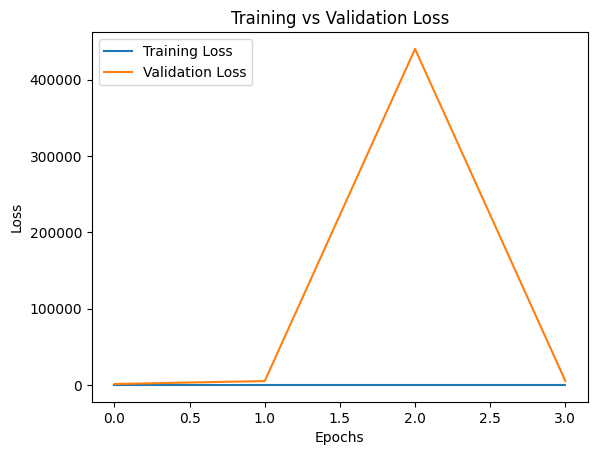

In [41]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [42]:
def taux_correct_predictions(y_test,y_pred,tolerance):
    correct_predictions = np.abs(y_test - y_pred) <= tolerance
    accuracy = np.mean(correct_predictions) * 100  
    print(f"Le taux de précision correctes de test avec tolerance={tolerance}: {accuracy:.2f}%")
predictions = model.predict(X_test_seq)
predictions = np.round(predictions).astype(int)
# Calcul des métriques pour l'ensemble de test
mse = mean_squared_error(y_test_seq, predictions)
mae = mean_absolute_error(y_test_seq, predictions)
r2 = r2_score(y_test_seq, predictions)
y_test = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

taux_correct_predictions(y_test,predictions,0)
taux_correct_predictions(y_test,predictions,1)
taux_correct_predictions(y_test,predictions,2)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

4427/4427 [==============================] - 8s 2ms/step
Le taux de précision correctes de test avec tolerance=0: 0.00%
Le taux de précision correctes de test avec tolerance=1: 0.00%
Le taux de précision correctes de test avec tolerance=2: 0.00%
MSE: 1198.3273, MAE: 34.5657, R²: -979.2918


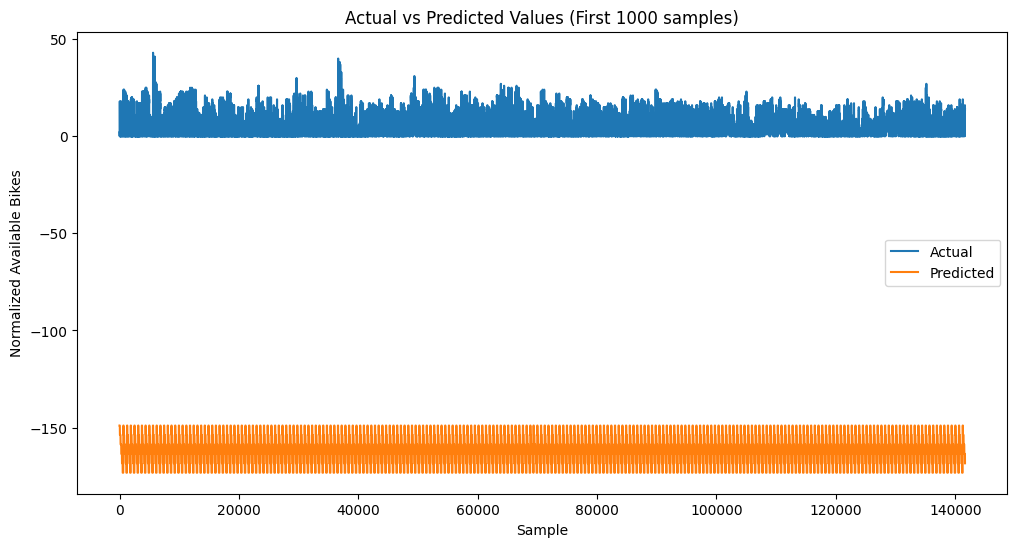

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Values (First 1000 samples)')
plt.xlabel('Sample')
plt.ylabel('Normalized Available Bikes')
plt.legend()
plt.show()